# Notes too self:
I have got to put more of yhis in functions cause this is so busy!
20
I want to run this again on the wonderful 20-60 first images found in the other dataset! I think that will give a much prettier image 

In [7]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
from PIL import Image
import cv2
from matplotlib.colors import LogNorm
import pandas as pd
import imutils
from cellpose import utils, io
from scipy.spatial import distance as dist
from imutils import perspective
import re
import tools
from radfil import radfil_class, styles
from astropy import units as u
import imageio
import skimage.morphology as sk_m
from fil_finder import FilFinder2D
from shapely.geometry import Polygon

segments_path = "/home/keeganfl/Desktop/Math_612_project/05-10-2015/cellpose_height/"

# Step 1
Loading up a list of segmentation (.npy) files to be run through the process. These files are then sorted by timepoint.

In [8]:
# Load files
files = os.listdir(segments_path)
for fichier in files[:]: 
    if not(fichier.endswith(".npy")):
        files.remove(fichier)

# Sort files by timepoint
files.sort(key = tools.natural_keys)

# Step 2
Load up the data and specifically save the full image and outlines for each cell. 

In [9]:
# Initialize lists
outl_list = []
img_list = []

# Fill lists with img and outline data from each file
for file in files[8:]:
    dat = np.load(segments_path + file, allow_pickle=True).item()
    # Create a list that contains each outline.
    outl = utils.outlines_list(dat['masks'])
    outl_list.append(outl)
    # Create a list that contains each image file. 
    image = dat["img"]
    img_list.append(image)

# Step 3
Create bounding boxes for each outline in each image. 

In [10]:
boxes_list = []
for outl in outl_list:
    boxes = tools.get_boxes(outl)
    boxes_list.append(boxes)

# Step 4
Perform cell tracking and save the ID, outline, and centers through time as lists. The reason we are saving the outlines as a list again is because these outlines will be aligned with the ID list, so we will always know which outline belongs to which specific cell over time.

In [11]:
# import the necessary packages
from collections import OrderedDict
class CentroidTracker():
    def __init__(self, maxDisappeared=1):
        # initialize the next unique object ID along with two ordered
        # dictionaries used to keep track of mapping a given object
        # ID to its centroid and number of consecutive frames it has
        # been marked as "disappeared", respectively
        self.nextObjectID = 0
        self.objects = OrderedDict()
        self.disappeared = OrderedDict()
        # store the number of maximum consecutive frames a given
        # object is allowed to be marked as "disappeared" until we
        # need to deregister the object from tracking
        self.maxDisappeared = maxDisappeared
    def register(self, rects, centroid, outline):
        # when registering an object we use the next available object
        # ID to store the centroid
        self.objects[self.nextObjectID] = (rects, centroid, outline)
        self.disappeared[self.nextObjectID] = 0
        self.nextObjectID += 1
    def deregister(self, objectID):
        # to deregister an object ID we delete the object ID from
        # both of our respective dictionaries
        del self.objects[objectID]
        del self.disappeared[objectID]
    def update(self, rects, outls):
        # initialize an array of input centroids for the current frame
        inputCentroids = np.zeros((len(rects), 2), dtype="int")
        # loop over the bounding box rectangles
        for (i, box) in enumerate(rects):
            # use the bounding box coordinates to derive the centroid
            cX = int(np.average(box[:, 0]))
            cY = int(np.average(box[:, 1]))
            inputCentroids[i] = (cX, cY)
        # if we are currently not tracking any objects take the input
        # centroids and register each of them
        if len(self.objects) == 0:
            for r, i, o in zip(rects, range(0, len(inputCentroids)), outls):
                self.register(r, inputCentroids[i], o)
        # otherwise, are are currently tracking objects so we need to
        # try to match the input centroids to existing object
        # centroids
        else:
            # grab the set of object IDs and corresponding centroids
            objectIDs = list(self.objects.keys())
            objectinfo = list(self.objects.values())
            objectCentroids = []
            for info in objectinfo:
                objectCentroids.append(info[1])
            # compute the distance between each pair of object
            # centroids and input centroids, respectively -- our
            # goal will be to match an input centroid to an existing
            # object centroid
            D = dist.cdist(np.array(objectCentroids), inputCentroids)
            # in order to perform this matching we must (1) find the
            # smallest value in each row and then (2) sort the row
            # indexes based on their minimum values so that the row
            # with the smallest value is at the *front* of the index
            # list
            rows = D.min(axis=1).argsort()
            # next, we perform a similar process on the columns by
            # finding the smallest value in each column and then
            # sorting using the previously computed row index list
            cols = D.argmin(axis=1)[rows]
            # in order to determine if we need to update, register,
            # or deregister an object we need to keep track of which
            # of the rows and column indexes we have already examined
            usedRows = set()
            usedCols = set()
            # loop over the combination of the (row, column) index
            # tuples
            for (row, col) in zip(rows, cols):
                # if we have already examined either the row or
                # column value before, ignore it
                # val
                if row in usedRows or col in usedCols:
                    continue
                # otherwise, grab the object ID for the current row,
                # set its new centroid, and reset the disappeared
                # counter
                objectID = objectIDs[row]
                self.objects[objectID] = (rects[col], inputCentroids[col], outls[col])
                self.disappeared[objectID] = 0
                # indicate that we have examined each of the row and
                # column indexes, respectively
                usedRows.add(row)
                usedCols.add(col)
            # compute both the row and column index we have NOT yet
            # examined
            unusedRows = set(range(0, D.shape[0])).difference(usedRows)
            unusedCols = set(range(0, D.shape[1])).difference(usedCols)
            # in the event that the number of object centroids is
            # equal or greater than the number of input centroids
            # we need to check and see if some of these objects have
            # potentially disappeared
            if D.shape[0] >= D.shape[1]:
                # loop over the unused row indexes
                for row in unusedRows:
                    # grab the object ID for the corresponding row
                    # index and increment the disappeared counter
                    objectID = objectIDs[row]
                    self.disappeared[objectID] += 1
                    # check to see if the number of consecutive
                    # frames the object has been marked "disappeared"
                    # for warrants deregistering the object
                    if self.disappeared[objectID] > self.maxDisappeared:
                        self.deregister(objectID)
            # otherwise, if the number of input centroids is greater
            # than the number of existing object centroids we need to
            # register each new input centroid as a trackable object
            else:
                for col in unusedCols:
                    self.register(rects[col], inputCentroids[col], outls[col])
        # return the set of trackable objects
        return self.objects

In [12]:
# initialize our centroid tracker and frame dimensions
ct = tools.CentroidTracker()
(H, W) = (None, None)

# Initialize a new set of lists that will contain lists of IDs, outlines, and centers for each image file. 
IDs_list = []
outl_new_list = []
centers_list = []
box_img = img_list.copy()


# loop over the outlines and boxes for each file.
for boxes, img, outls in zip(boxes_list, box_img, outl_list):
    # Draw an outline of each box onto the original image
    for box in boxes:
        (startX, startY, endX, endY) = box.astype("int")
    # update our centroid tracker using the computed set of bounding box rectangles
    objects = ct.update(boxes, outls)
    # Initialize a new set of lists
    IDs = []
    outl_new = []
    centers = []
    # loop over the tracked objects
    for (objectID, info) in objects.items():
        # draw both the ID of the object and the centroid of the
        # object on the output frame
        text = "ID {}".format(objectID)
        # append the object ID and its associated outline and center to the lists. 
        IDs.append(objectID)
        outl_new.append(info[1])
        centers.append(info[0])
    IDs_list.append(IDs)
    outl_new_list.append(outl_new)
    centers_list.append(centers)

# Step 5
Determining the number of pixels which overlap between the different outlines

In [13]:
def get_overlap(outl, boxes):
    cell_overlaps = []
    for out_cell, box_cell in zip(outl, boxes):
        adj = 0
        for out_oth, box_oth in zip(outl, boxes):
            p1 = Polygon(box_cell)
            p2 = Polygon(box_oth)
            # centroid distance cuttod=ff = 150 pixels. 
            if p1.intersects(p2) == False or p1 == p2:
                continue
            for pixel1 in out_cell:
                for pixel2 in out_oth:
                    distx = np.abs(pixel1[0]-pixel2[0])
                    disty = np.abs(pixel1[1]-pixel2[1])
                    if distx + disty == 1:
                        adj = adj + 1
        cell_overlaps.append(adj)
    return cell_overlaps 

In [14]:
# about 20 seconds, twice as fast!!! Will probably have even greater gains with higher cell density. 
overl_list = []
for outl, boxes in zip(outl_list, boxes_list):
    overl_list.append(get_overlap(outl, boxes))

In [88]:
def radobj_maker(path, IDs_list, time_list):
    '''
    This iterative function loads up a set of images, masks and skeletons for individual cells which were created 
    from a set of parent images taken at different timepoints. For each of these individual cells, it then uses
    the radfil package to estimate the radial profile of the cell which is then saved in a list of radfil objects. 
    '''
    radobj_list = []
    for ID_set, time in zip(IDs_list, time_list):
        radobj_set = []
        print(time)
        for idx in (ID_set):
            # Load the image and convert to grayscale. 
            fil_image =imageio.imread(path + str(time) + "/cells/cell_" + str(idx) + ".png")
            fil_image = cv2.cvtColor(fil_image, cv2.COLOR_BGR2GRAY)
            
            # Load the mask and convert to grayscale
            fil_mask=imageio.imread(path + str(time) + "/masks/mask_" + str(idx) + ".png")
            fil_mask = cv2.cvtColor(fil_mask, cv2.COLOR_BGR2GRAY)
            fil_mask = np.array(fil_mask, dtype=bool)

            ###!!!### Replace with a call to Hasti's stuff
            fil_spine = sk_m.skeletonize(fil_mask)
            fil_spine = np.array(fil_spine, dtype=bool)
            
            # Use radfil to create a radial profil object and then append this object to a list.
            # We will use the data stored in this object to calculate height and radial profile along the
            # medial axis. 
            radobj=radfil_class.radfil(fil_image, mask=fil_mask, filspine=fil_spine, distance=200)
            radobj.build_profile(samp_int=1, shift = False)
            radobj_set.append(radobj)
        radobj_list.append(radobj_set)
    return(radobj_list)

NameError: name 'time_list' is not defined

In [17]:
path = "Individual_cells/05-10-2015/"

fil_image =imageio.imread(path + str(10061218) + "/cells/cell_" + str(idx) + ".png")
fil_image = cv2.cvtColor(fil_image, cv2.COLOR_BGR2GRAY)
            
# Load the mask and convert to grayscale
fil_mask=imageio.imread(path + str(time) + "/masks/mask_" + str(idx) + ".png")
fil_mask = cv2.cvtColor(fil_mask, cv2.COLOR_BGR2GRAY)
fil_mask = np.array(fil_mask, dtype=bool)

###!!!### Replace with a call to Hasti's stuff
fil_spine = sk_m.skeletonize(fil_mask)
fil_spine = np.array(fil_spine, dtype=bool)
            
# Use radfil to create a radial profil object and then append this object to a list.
# We will use the data stored in this object to calculate height and radial profile along the
# medial axis. 
radobj=radfil_class.radfil(fil_image, mask=fil_mask, filspine=fil_spine, distance=200)
radobj.build_profile(samp_int=1, shift = False)

NameError: name 'idx' is not defined

In [19]:
fil_spine = imageio.imread(path + str(10061218) + "/skeletons/fullmask_9.png")

/home/keeganfl/miniconda3/envs/cellpose/lib/python3.8/site-packages/PIL/Image.py:2896: DecompressionBombWarning: Image size (97200000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


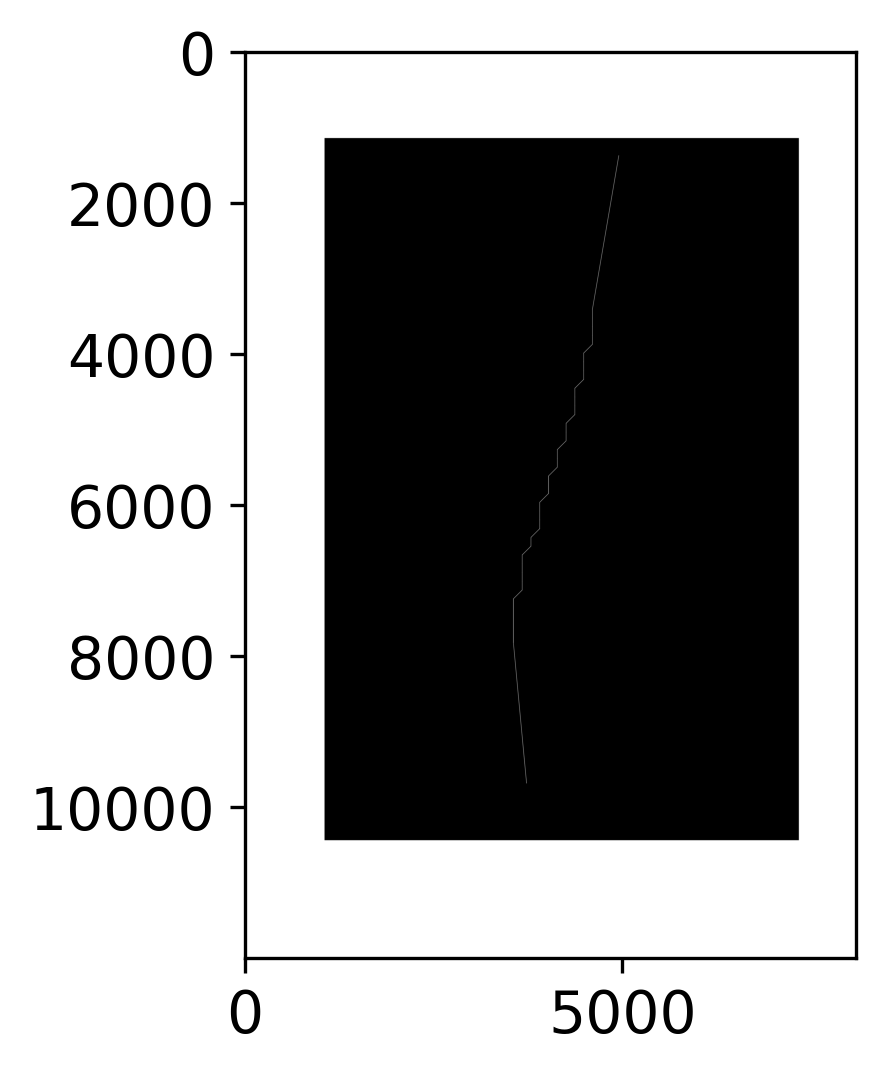

In [20]:
plt.imshow(fil_spine)

In [23]:
plt.plot(o

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed